# CS545: Machine Learning
## Fall 2019 - Final Project

Brent Staab and Seth Neal Hughes

# CODE
## Import code needed in this notebook

In [1]:
import numpy as np
import pandas
import torch
import copy

import os
import sys
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

# sklearn isn't part of standard install, had to run the following ...
# pip install sklearn
from sklearn.model_selection import train_test_split

from sys import platform
import neuralnetworks as nn

## Definition of `NeuralNetworkClassifier`

In [2]:
# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier
class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    # Input parameters:
    #    n_inputs: number of inputs
    #    n_hiddens_list: a list containing the number of hidden layers
    #    classes       : a list of classes (integer) to classify
    #    use_torch     : flag indicating which library to use for the implementation
    #                    False (default) - Use numpy
    #                    True - Use pytorchc
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        self.classes = np.array(classes) # to allow argmax in use()
        
        # Set functions used by the class based on 'use_torch' flag
        if use_torch:
            self.log    = torch.log
            self.exp    = torch.exp
            self.sum    = torch.sum
            self.argmax = torch.argmax
        else:
            self.log    = np.log
            self.exp    = np.exp
            self.sum    = np.sum
            self.argmax = np.argmax

    # built-in function used to compute the "official" string representation for this object
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.classes}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
    
    # Override base class implementation to do nothing
    def _standardizeT(self, T):
        return T
    
    # Override base class implementation to do nothing
    def _unstandardizeT(self, T):
        return T
    
    # Override base class implementation to add classification specific 
    # behavior.  Just call g(s) (a.k.a. softmax) on base class result
    # Input
    #    X: input data
    # Output
    #    Y: output of neural network
    #    Z: the inputs, as a list, for each layer
    def _forward_pass(self, X):
        Y, Z = super()._forward_pass(X)
        Y = self._g(Y)
        
        return Y, Z

    # Override base class implementation
    # Return neg_mean_log_likelihood
    # Input
    #    w: Weights to use for nn
    #    X: Input data to process
    #    T: Targets
    # Output
    #    neg_mean_log_likelihood
    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return -self.mean(self.log(Y) * T)
        
    # Override base class implementation
    # Input
    #    neg_mean_log_likelihood: Output of _objectiveF
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)
    
    # Override base class implementation
    # Return neg_mean_log_likelihood
    # Input
    #    X                    : Input data to process
    #    T                    : Targets
    #    n_epochs             : number of max num iterations to train
    #    method               : Which algorithm (scg, sgd, adam) to use for training
    #    verbose              : flag (default false) to enable/disable extra messages
    #    save_weights_history : flag (default false) to enable/disable saving of the weights
    #    learning_rate        : value used for sgd and adam
    #    momentum_rate        : value used for sgd and adam
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0):
        
        # Convert targets into indicator variables
        T_indicator_vars = self._make_indicator_variables(T)
        
        # Call base class with indicator variables instead of target values
        return super().train(X, T_indicator_vars, n_epochs, method,
                          verbose, save_weights_history,
                          learning_rate, momentum_rate)
    
    # Override base class implementation
    # Return output of trained network on input data
    # Input
    #    X           : Input data to process
    #    all_outputs : Flag (default false) to control what is returned from this function
    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        
        # Convert Y to 'classes' 
        # - argmax returns an index into the class array, not the value
        Y_class_idx = list(self.argmax(Y, axis=1))
        Y_classes = np.array([self.classes[i] for i in Y_class_idx]).reshape((-1,1))
        
        if self.use_torch:
            Y_classes = torch.tensor(Y_classes)
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        
        return (Y_classes, Y, Z[1:]) if all_outputs else Y_classes, Y
        
    # Function to convert a list of target values into an array 
    # of 'indicator variables'
    def _make_indicator_variables(self, T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)
    
    # Function to compute the 'softmax'
    def _g(self, Y):
        fs = self.exp(Y)
        denom = self.sum(fs, axis=1).reshape((-1,1))
        gs = fs / denom
        return gs

## Helper functions

In [3]:
# Helper function to create a nn, run a test and return results
#def run_test(ni, hl, cl, X_train, T_train, X_test, T_test, e, m, lr, mr):
def run_test(ni, cl, X_train, T_train, X_test, T_test):
    hl = [400]
    e = 1000
    m = 'scg'
    lr = 0.01
    mr = 0.0
    
    nnet = NeuralNetworkClassifier(ni, hl, cl, False)
    nnet.train(X_train, T_train, e, m, lr, mr)
    Y_classes, Y = nnet.use(X_test)
    n_correct = (Y_classes == T_test).sum()
    n_total = T_test.shape[0]
    pct_correct = ((n_correct/n_total)*100)
    return [n_correct, n_total, pct_correct, T_test, Y_classes, nnet.get_error_trace()]

In [4]:
# Helper function to print/plot results
def print_results(results):
    T_diff = results[3] - results[4]                    # Diff between actual and predicted values
    num_false_positive = np.where(T_diff < 0)[0].shape[0]     # Num incorrectly indentified as HOF/A*
    num_false_negative = np.where(T_diff > 0)[0].shape[0]     # Num HOF/A* not identified correctly

    print(f'{results[0]} out of {results[1]} '          # Print total number of missdetections
          f'samples or {results[2]:.2f} percent.')         # 
    print(f'Number of false positives({num_false_positive})') # Print number of false positive
    print(f'Number of false negative ({num_false_negative})') # Print number of false negatives
                                                              #
    plt.figure(figsize=(20, 5))                               # Set the overall plot size
    plt.subplot(1, 2, 1)                                      # Define plot area and select 1st subplot
    plt.title('Error Trace')                                  # Add subplot 1 title
    plt.xlabel('epoch')                                       # Add subplot 1 X-axis label
    plt.ylabel('MSE')                                         # Add subplot 1 Y-axis label
    plt.plot(results[5], '-')                              # Add first data set to plot
                                                              #
    plt.grid(True)                                            # Enable the grid for subplot 1
    plt.subplot(1, 2, 2)                                      # Select 2nd subplot
    plt.title('NN Output')                                    # Add subplot 2 title
    plt.xlabel('Data point')                                  # Add subplot 2 X-axis label
    plt.ylabel('Actual vs Expected')                          # Add subplot 2 Y-axis label
    
    plt.plot(T_diff, 'o-')                                    # Add data set to plot
    axes = plt.gca()                                          # Get Current Axis for plot 2
    axes.set_ylim([-1,1])                                     # Set Y-axis limits (0-100) for %
    plt.grid(True)                                            # Enable the grid for subplot 2

# DATA

The data set can be found at http://www.seanlahman.com/baseball-archive/statistics  

#### Import data from files

In [5]:
# This selects the correct path based on OS
if platform == 'linux':
    people_file      = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/People.csv'
    batting_file     = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/Batting.csv'
    fielding_file    = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/Fielding.csv'
    pitchcing_file   = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/Pitching.csv'
    halloffame_file  = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/HallOfFame.csv'
    allstarfull_file = 'baseballdatabank-2019.2/baseballdatabank-2019.2/core/AllstarFull.csv'
    hof_pch_results_all_file    = 'hof_pch_results_all.data'
    hof_pch_results_split_file  = 'hof_pch_results_split.data'
    hof_fld_results_all_file    = 'hof_fld_results_all.data'
    hof_fld_results_split_file  = 'hof_fld_results_split.data'
    astr_pch_results_all_file   = 'astr_pch_results_all.data'
    astr_pch_results_split_file = 'astr_pch_results_split.data'
    astr_fld_results_all_file   = 'astr_fld_results_all.data'
    astr_fld_results_split_file = 'astr_fld_results_split.data'
else:
    people_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\People.csv'
    batting_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\Batting.csv'
    fielding_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\Fielding.csv'
    pitchcing_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\Pitching.csv'
    halloffame_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\HallofFame.csv'
    allstarfull_file = 'C:\\Users\\user\\Notebooks\\CS545\\Project\\baseballdatabank-2019.2\\core\\AllstarFull.csv'

# Players
df_players = pandas.read_csv(people_file)
df_players = df_players['playerID']

# Batting information for players
df_batting = pandas.read_csv(batting_file)
df_batting.fillna(0, inplace=True)

# Fielding information
df_fielding = pandas.read_csv(fielding_file)
df_fielding.fillna(0, inplace=True)

# Pitching information
df_pitching = pandas.read_csv(pitchcing_file)
df_pitching.fillna(0, inplace=True)

# HoF
df_hof = pandas.read_csv(halloffame_file)
df_hof.fillna(0, inplace=True)
df_hof = df_hof.loc[(df_hof['inducted'] == 'Y') & (df_hof['category'] == 'Player')]
df_hof = df_hof['playerID']
hof_list = list(df_hof.unique())

#All-Star
df_all_star = pandas.read_csv(allstarfull_file)
df_all_star.fillna(0, inplace=True)
# allstar_list = list(df_all_star.unique()) # list of all star players
df_all_star = df_all_star['playerID']
allstar_list = list(df_all_star.unique())

### Generate career statistics

###### Pitching Statistics

In [6]:
# Create new dataframe to hold career stats for pitchers
# A pitcher is anyone showing up in the 'df_pitching' dataframe, which was imported above
df_career_pitching = pandas.DataFrame()

if os.path.isfile('df_career_pitching.csv'):
    df_career_pitching = pandas.read_csv('df_career_pitching.csv')
else:
    start_time = time.time()
    
    # Build data set for each pitcher in the pitching database
    count = 0
    for player in df_pitching['playerID'].unique():
        # Set variable to '1' if player is in the HOF, else set to '0'
        in_hof = 1 if player in hof_list else 0
    
        # Get all pitching statistics for this player and sum
        ds_pitch = df_pitching.loc[df_pitching['playerID'] == player].sum()
        
        # Get the fielding statistics, only when they were a pitcher, for this player and sum
        ds_field = df_fielding.loc[(df_fielding['playerID'] == player) & (df_fielding['POS'] == 'P')].sum()
        
        # Determine the number of years played (should be the same in both sets, but who knows)
        pitch_yrs = ds_pitch['stint']
        field_yrs = ds_field['stint']
        max_yrs = max(pitch_yrs, field_yrs)
        
        # Get rid of the fields we don't want in both data sets
        ds_pitch.drop(['yearID', 'teamID', 'lgID'], inplace=True, errors='ignore')
        ds_field.drop(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS', 'WP'], inplace=True, errors='ignore')
        
        # Overwrite specific fields
        ds_pitch['playerID'] = player
        ds_pitch['stint'] = max_yrs
        ds_pitch['ERA'] = ds_pitch['ERA'] / pitch_yrs
        
        # Add 'HOF' field to data set
        ds_field['HOF'] = in_hof
        
        # Append fielding data to batting data and append to the dataframe
        df_career_pitching = df_career_pitching.append(ds_pitch.append(ds_field), ignore_index=True)
        count += 1
    
    # The order of the columns gets messed up, so fix at the end
    # Move 'stint' to the front, then 'playerID' so we'll get 'playerID' 'stint' ...
    # Move 'HOF' to the end of the list so we'll get ... 'HOF'
    df_career_pitching.drop(['Unnamed: 0'], axis=1, errors='ignore')
    col_name_lst = list(df_career_pitching.columns)
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('stint')))
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('playerID')))
    col_name_lst.append(col_name_lst.pop(col_name_lst.index('HOF')))
    df_career_pitching = df_career_pitching[col_name_lst]

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'It took {elapsed_time} seconds to process the pitching data. count({count})')
    
    # Save to file so we only need to generate once    
    df_career_pitching.to_csv('df_career_pitching.csv')

df_career_pitching.drop(['Unnamed: 0'], axis=1, errors='ignore', inplace=True)
df_career_pitching.drop(['lgID'], axis=1, errors='ignore', inplace=True)
df_career_pitching.fillna(0, inplace=True)

###### Fielding Statistics

In [7]:
# Create new dataframe to hold career stats for fielders
# A fielder is anyone showing up in the 'df_fielding' dataframe 
# AND NOT in the 'df_pitching' dataframe, both were imported above
df_career_fielder = pandas.DataFrame()

if os.path.isfile('df_career_fielder.csv'):
    df_career_fielder = pandas.read_csv('df_career_fielder.csv')
else:
    start_time = time.time()
    
    # Get a list of pitchers, these will be excluded from processing
    pitchers = list(df_pitching['playerID'].unique())
    
    # Build data set for each player in the fielding database
    count = 0
    for player in df_fielding['playerID'].unique():
        
        # If the player is a pitcher, exclude them from this dataset
        if player in pitchers:
            continue
        
        # Set variable to '1' if player is in the HOF, else set to '0'
        in_hof = 1 if player in hof_list else 0
        
        # Get all batting and fielding information for this player and sum
        ds_bat = df_batting.loc[df_batting['playerID'] == player].sum()
        ds_fld = df_fielding.loc[df_fielding['playerID'] == player].sum()
        
        # Determine the number of years played (should be the same in both sets, but who knows)
        bat_yrs = ds_bat['stint']
        fld_yrs = ds_fld['stint']
        max_yrs = max(bat_yrs, fld_yrs)
        
        # Get rid of the fields we don't want
        ds_bat.drop(['yearID', 'teamID', 'lgID', 'POS', 'G'], inplace=True, errors='ignore')
        ds_fld.drop(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS', 'SB', 'CS'], inplace=True, errors='ignore')
        
        # Overwrite specific fields
        ds_bat['playerID'] = player
        ds_bat['stint'] = max_yrs
        
        # Add 'HOF' field to data set
        ds_fld['HOF'] = in_hof
        
        # Append fielding data to batting data and append to the dataframe
        df_career_fielder = df_career_fielder.append(ds_bat.append(ds_fld), ignore_index=True)
        
        count += 1
    
    # The order of the columns gets messed up, so fix at the end
    # Move 'stint' to the front, then 'playerID' so we'll get 'playerID' 'stint' ...
    # Move 'HOF' to the end of the list so we'll get ... 'HOF'
    col_name_lst = list(df_career_fielder.columns)
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('stint')))
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('playerID')))
    col_name_lst.append(col_name_lst.pop(col_name_lst.index('HOF')))
    df_career_fielder = df_career_fielder[col_name_lst]
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'It took {elapsed_time} seconds to process the fielder data. count({count})')

    # Save to file so we only need to generate once    
    df_career_fielder.to_csv('df_career_fielder.csv')

In [8]:
# Create new dataframe to hold season stats for pitchers
# A pitcher is anyone showing up in the 'df_pitching' dataframe, which was imported above
df_season_pitching = pandas.DataFrame()

if os.path.isfile('df_season_pitching.csv'):
    df_season_pitching = pandas.read_csv('df_season_pitching.csv')
else:
    start_time = time.time()
    
    count = 0

    # Process all players in the pitching db
    for player in df_pitching['playerID'].unique():
        # Process each season for this player 
        for year in df_pitching.loc[(df_pitching['playerID'] == player)]['yearID'].unique():
            # Set variable to '1' if player is in the HOF, else set to '0'
            all_star = int(not df_all_star.loc[((df_all_star['playerID'] == player) & 
                                                (df_all_star['yearID'] == year))].empty)
        
            # Get all pitching statistics for this player and season
            df_pitch = df_pitching.loc[(df_pitching['playerID'] == player) & 
                                       (df_pitching['yearID'] == year)]

            # Get the fielding statistics for this player and season
            df_field = df_fielding.loc[(df_fielding['playerID'] == player) & 
                                       (df_fielding['yearID'] == year) &
                                       (df_fielding['POS'] == 'P')]
            
            # There may be more than one entry for a player + year (changed teams?)
            # Average all stats for each column.
            ds_pitch = df_pitch.mean()
            ds_field = df_field.mean()
        
            # Get rid of the fields we don't want in both data sets
            ds_pitch.drop(['stint', 'teamID', 'lgID'], inplace=True, errors='ignore')
            ds_field.drop(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS', 'WP'], inplace=True, errors='ignore')

            # Add 'playerID' to pitch data set (it was lost during 'mean' step 
            # Add all-star' field to data set
            ds_pitch['playerID'] = player
            ds_field['all-star'] = all_star
            
            # Append fielding data to batting data and append to the dataframe
            df_season_pitching = df_season_pitching.append(ds_pitch.append(ds_field), ignore_index=True)
            
            count += 1
    
    # The order of the columns gets messed up, so fix at the end
    # Move 'yearID' to the front, then 'playerID' so we'll get 'playerID' 'yearID' ...
    # Move 'all-star' to the end of the list so we'll get ... 'all-star'
    #df_career_pitching.drop(['Unnamed: 0'], axis=1, errors='ignore')
    col_name_lst = list(df_season_pitching.columns)
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('yearID')))
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('playerID')))
    col_name_lst.append(col_name_lst.pop(col_name_lst.index('all-star')))
    df_season_pitching = df_season_pitching[col_name_lst]

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'It took {elapsed_time} seconds to process the pitching data. count({count})')
    
    # Save to file so we only need to generate once    
    df_season_pitching.to_csv('df_season_pitching.csv')

In [9]:
# Create new dataframe to hold season stats for pitchers
# A pitcher is anyone showing up in the 'df_pitching' dataframe, which was imported above
df_season_fielding = pandas.DataFrame()

if os.path.isfile('df_season_fielding.csv'):
    df_season_fielding = pandas.read_csv('df_season_fielding.csv')
else:
    start_time = time.time()
    
    count = 0

    # Get a list of pitchers, these will be excluded from processing
    pitchers = list(df_pitching['playerID'].unique())
    
    # Process all players in the fielding db
    for player in df_fielding['playerID'].unique():
        
        # If the player is a pitcher, exclude them from this dataset
        if player in pitchers:
            continue
        
        # Process each season for this player 
        for year in df_fielding.loc[(df_fielding['playerID'] == player)]['yearID'].unique():
            # Set variable to '1' if player is in the HOF, else set to '0'
            all_star = int(not df_all_star.loc[((df_all_star['playerID'] == player) & 
                                                (df_all_star['yearID'] == year))].empty)
        
            # Get all batting statistics for this player and season
            df_hit = df_batting.loc[(df_batting['playerID'] == player) & 
                                    (df_batting['yearID'] == year)]

            # Get the fielding statistics for this player and season
            df_field = df_fielding.loc[(df_fielding['playerID'] == player) & 
                                       (df_fielding['yearID'] == year)]
            
            # There may be more than one entry for a player + year (changed teams?)
            # Average all stats for each column.
            ds_hit = df_hit.mean()
            ds_field = df_field.mean()
        
            # Get rid of the fields we don't want in both data sets
            ds_hit.drop(['stint'], inplace=True, errors='ignore')
            ds_field.drop(['yearID', 'stint', 'G', 'CS', 'SB'], inplace=True, errors='ignore')

            # Add 'playerID' to pitch data set (it was lost during 'mean' step 
            # Add all-star' field to data set
            ds_hit['playerID'] = player
            ds_field['all-star'] = all_star
            
            # Append fielding data to batting data and append to the dataframe
            df_season_fielding = df_season_fielding.append(ds_hit.append(ds_field), ignore_index=True)
            
            count += 1
    
    # The order of the columns gets messed up, so fix at the end
    # Move 'yearID' to the front, then 'playerID' so we'll get 'playerID' 'yearID' ...
    # Move 'all-star' to the end of the list so we'll get ... 'all-star'
    col_name_lst = list(df_season_fielding.columns)
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('yearID')))
    col_name_lst.insert(0, col_name_lst.pop(col_name_lst.index('playerID')))
    col_name_lst.append(col_name_lst.pop(col_name_lst.index('all-star')))
    df_season_fielding = df_season_fielding[col_name_lst]

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'It took {elapsed_time} seconds to process the fielding data. count({count})')
    
    # Save to file so we only need to generate once    
    df_season_fielding.to_csv('df_season_fielding.csv')

#### Summary of career statistics

In [10]:
num_fielders = df_career_fielder.count()[0]
num_pitchers = df_career_pitching.count()[0]
num_players = num_fielders + num_pitchers
num_hof = df_hof.count()
pct_hof = (num_hof / num_players) * 100

hofers = set(df_hof.unique())
pitchers = set(df_career_pitching['playerID'].unique())
fielders = set(df_career_fielder['playerID'].unique())
num_hof_pitchers = len(pitchers.intersection(hofers))
pct_hof_pitchers = (num_hof_pitchers / num_pitchers) * 100
num_hof_fielders = len(fielders.intersection(hofers))
pct_hof_fielders = (num_hof_fielders / num_fielders) * 100

print('-----------------Summary--------------------------')
print(f'Total number of pitchers - {num_pitchers}')
print(f'Total number of fielders - {num_fielders}')
print(f'Total number of players - {num_players}')
print('--------------------------------------------------')
print(f'Number of pitchers in HOF ({num_hof_pitchers}) or  ({pct_hof_pitchers:0.3f})%')
print(f'Number of fielders in HOF ({num_hof_fielders}) or  ({pct_hof_fielders:0.3f})%')
print(f'Total in HOF ({num_hof}) or ({pct_hof:0.3f})%')

-----------------Summary--------------------------
Total number of pitchers - 9655
Total number of fielders - 9574
Total number of players - 19229
--------------------------------------------------
Number of pitchers in HOF (96) or  (0.994)%
Number of fielders in HOF (134) or  (1.400)%
Total in HOF (256) or (1.331)%


These statistics show how hard it is for a player to make the hall of fame.  This also means that the data set is exteremely unbalanced where there are more players who do NOT make the HOF than do.

#### Summary of single season statistics

In [11]:
num_seasons_played = df_season_fielding.count()[0]
num_seasons_all_star = df_all_star.count()
pct_seasons_all_star = (num_seasons_all_star / num_seasons_played) * 100
print('-----------------Summary--------------------------')
print(f'Total number of seasons played   - {num_seasons_played}')
print(f'Total number of all-star seasons - {num_seasons_all_star}')
print(f'Percent all-star seeasons        - {pct_seasons_all_star:0.3f}')

-----------------Summary--------------------------
Total number of seasons played   - 49390
Total number of all-star seasons - 5291
Percent all-star seeasons        - 10.713


## Experiments

### Hall-of-Fame for pitchers

##### Setup dataset

In [12]:
# Get all data and partition into 80% training 20% test data
pitch_train_data, pitch_test_data = train_test_split(df_career_pitching, test_size=0.2)

# Get the input data and convert to numpy variables
Xdata_pitch  = df_career_pitching.loc[:,'stint':'ZR'].values
Xtrain_pitch =   pitch_train_data.loc[:,'stint':'ZR'].values
Xtest_pitch  =    pitch_test_data.loc[:,'stint':'ZR'].values

# Get the target values and convert to numpy variables
Tdata_pitch  = df_career_pitching.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttrain_pitch =   pitch_train_data.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttest_pitch  =    pitch_test_data.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)

##### Find best network using 100% of the data

In [13]:
# Extract info from the data sets
num_inputs = Xdata_pitch.shape[1]
class_list = np.unique(Tdata_pitch)

print(f'Xdata.shape({Xdata_pitch.shape}) Tdata.shape({Tdata_pitch.shape})')
print(f'num_inputs({num_inputs}) class_list({class_list})')

Xdata.shape((9655, 35)) Tdata.shape((9655, 1))
num_inputs(35) class_list([0 1])


In [14]:
%%capture
if os.path.isfile('hof_pch_results_all_file.data'):
    with open('hof_pch_results_all_file.data', 'rb') as filehandle:
        hof_pch_results_all = pickle.load(filehandle)
else: 
    hof_pch_results_all = run_test(num_inputs, class_list, Xdata_pitch, Tdata_pitch, Xdata_pitch, Tdata_pitch)
    with open('hof_pch_results_all_file.data', 'wb') as filehandle:
        pickle.dump(hof_pch_results_all, filehandle)

9629 out of 9655 samples or 99.73 percent.
Number of false positives(0)
Number of false negative (26)


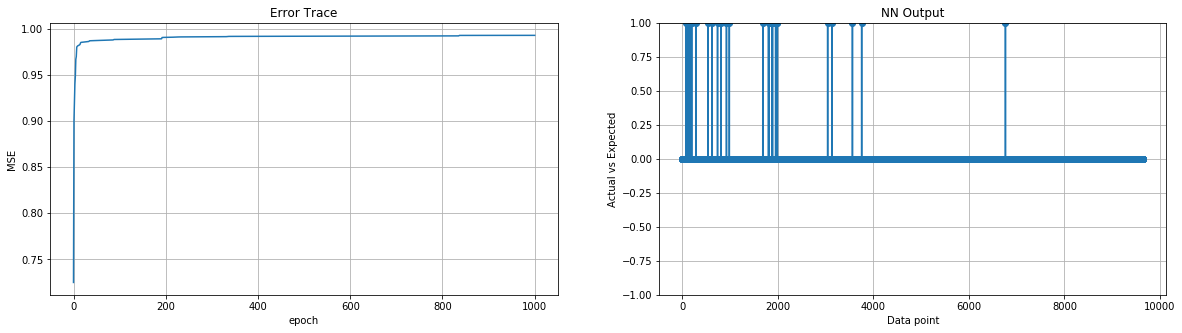

In [15]:
print_results(hof_pch_results_all)

Using 100% of the data for training and testing, the neural network was able to accurately predict 99.73% of the samples correctly.  It shows that there were 0 false positives which the network says are in the Hall of Fame but are really not, and 26 false negatives which are players who are actually in the Hall of fame but were not predicted by the network.

In [16]:
%%capture
if os.path.isfile('hof_pch_results_split_file.data'):
    with open('hof_pch_results_split_file.data', 'rb') as filehandle:
        hof_pch_results_split = pickle.load(filehandle)
else: 
    hof_pch_results_split = run_test(num_inputs, class_list, Xtrain_pitch, Ttrain_pitch, Xtest_pitch, Ttest_pitch)
    with open('hof_pch_results_split_file.data', 'wb') as filehandle:
        pickle.dump(hof_pch_results_split, filehandle)        

1916 out of 1931 samples or 99.22 percent.
Number of false positives(3)
Number of false negative (12)


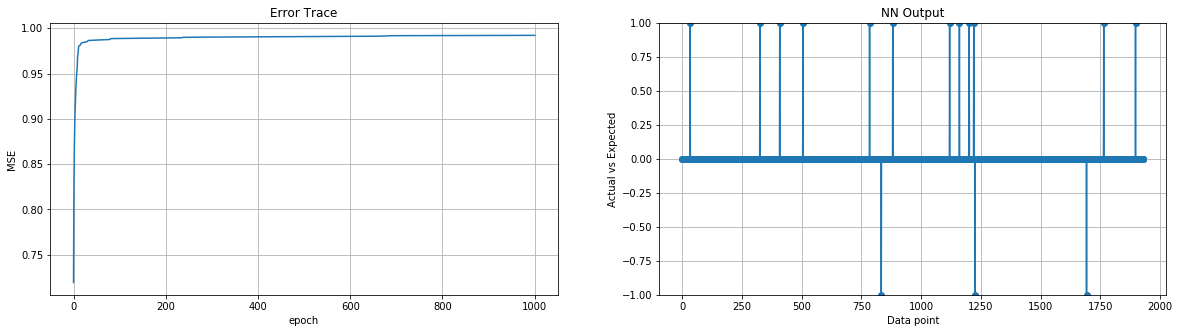

In [17]:
print_results(hof_pch_results_split)

Using 80% of the data for training and 20% for testing, the neural network was able to accurately predict 99.38% of the samples correctly. It shows that there were 2 false positives which the network says are in the Hall of Fame but are really not, and 10 false negatives which are players who are actually in the Hall of fame but were not predicted by the network.

#### Fielding data

In [18]:
# Get all data and partition into 80% training 20% test data
train_fld_data, test_fld_data = train_test_split(df_career_fielder, test_size=0.2)

# Get the input data and convert to numpy variables
Xdata_fld  = df_career_fielder.loc[:,'stint':'ZR'].values
Xtrain_fld =    train_fld_data.loc[:,'stint':'ZR'].values
Xtest_fld  =     test_fld_data.loc[:,'stint':'ZR'].values

# Get the target values and convert to numpy variables
Tdata_fld  = df_career_fielder.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttrain_fld =    train_fld_data.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttest_fld  =     test_fld_data.loc[:,'HOF'].reset_index().values[:,1].reshape(-1, 1).astype(int)

# Extract info from the data sets
num_inputs = Xdata_fld.shape[1]
class_list = np.unique(Tdata_fld)

print(f'Xdata_fld.shape({Xdata_fld.shape}) Tdata_fld.shape({Tdata_fld.shape})')
print(f'num_inputs({num_inputs}) class_list({class_list})')

Xdata_fld.shape((9574, 25)) Tdata_fld.shape((9574, 1))
num_inputs(25) class_list([0 1])


In [19]:
%%capture
if os.path.isfile('hof_fld_results_all_file.data'):
    with open('hof_fld_results_all_file.data', 'rb') as filehandle:
        hof_fld_results_all = pickle.load(filehandle)
else: 
    hof_fld_results_all = run_test(num_inputs, class_list, Xdata_fld, Tdata_fld, Xdata_fld, Tdata_fld)
    with open('hof_fld_results_all_file.data', 'wb') as filehandle:
        pickle.dump(hof_fld_results_all, filehandle)

9568 out of 9574 samples or 99.94 percent.
Number of false positives(0)
Number of false negative (6)


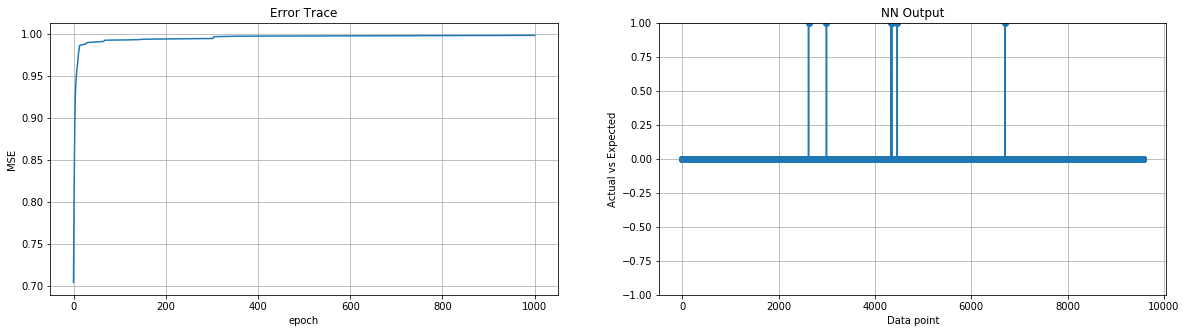

In [20]:
print_results(hof_fld_results_all)

In [21]:
%%capture
if os.path.isfile('hof_fld_results_split_file.data'):
    with open('hof_fld_results_split_file.data', 'rb') as filehandle:
        hof_fld_results_split = pickle.load(filehandle)
else: 
    hof_fld_results_split = run_test(num_inputs, class_list, Xtrain_fld, Ttrain_fld, Xtest_fld, Ttest_fld)
    with open('hof_fld_results_split_file.data', 'wb') as filehandle:
        pickle.dump(hof_fld_results_split, filehandle)


1894 out of 1915 samples or 98.90 percent.
Number of false positives(7)
Number of false negative (14)


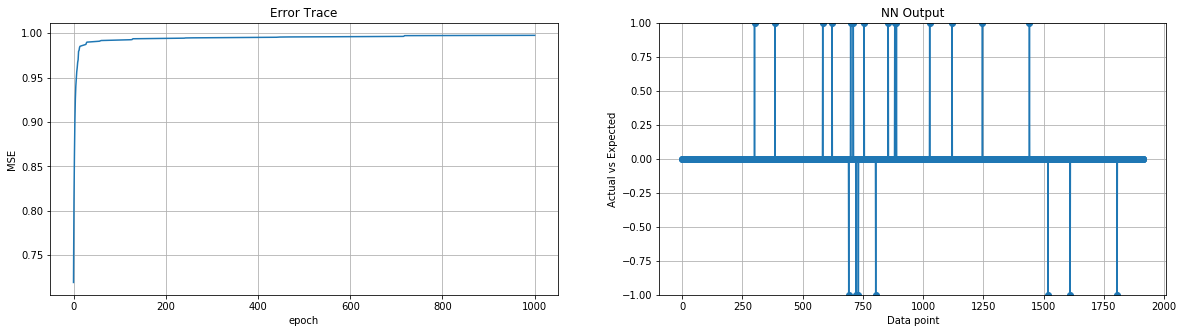

In [22]:
print_results(hof_fld_results_split)

## All Star

In [23]:
# Get all data and partition into 80% training 20% test data
pitch_train_data, pitch_test_data = train_test_split(df_season_pitching, test_size=0.2)

# Get the input data and convert to numpy variables
Xdata_pitch  = df_season_pitching.loc[:,'yearID':'ZR'].values
Xtrain_pitch =   pitch_train_data.loc[:,'yearID':'ZR'].values
Xtest_pitch  =    pitch_test_data.loc[:,'yearID':'ZR'].values

# Get the target values and convert to numpy variables
Tdata_pitch  = df_season_pitching.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttrain_pitch =   pitch_train_data.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttest_pitch  =    pitch_test_data.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)

# Extract info from the data sets
num_inputs = Xdata_pitch.shape[1]
class_list = np.unique(Tdata_pitch)

print(f'Xdata.shape({Xdata_pitch.shape}) Tdata.shape({Tdata_pitch.shape})')
print(f'num_inputs({num_inputs}) class_list({class_list})')

Xdata.shape((43157, 35)) Tdata.shape((43157, 1))
num_inputs(35) class_list([0 1])


In [24]:
%%capture
if os.path.isfile('astr_pch_results_all_file.data'):
    with open('astr_pch_results_all_file.data', 'rb') as filehandle:
        astr_pch_results_all = pickle.load(filehandle)
else: 
    astr_pch_results_all = run_test(num_inputs, class_list, Xdata_pitch, Tdata_pitch, Xdata_pitch, Tdata_pitch)
    with open('astr_pch_results_all_file.data', 'wb') as filehandle:
        pickle.dump(astr_pch_results_all, filehandle)

41954 out of 43157 samples or 97.21 percent.
Number of false positives(260)
Number of false negative (943)


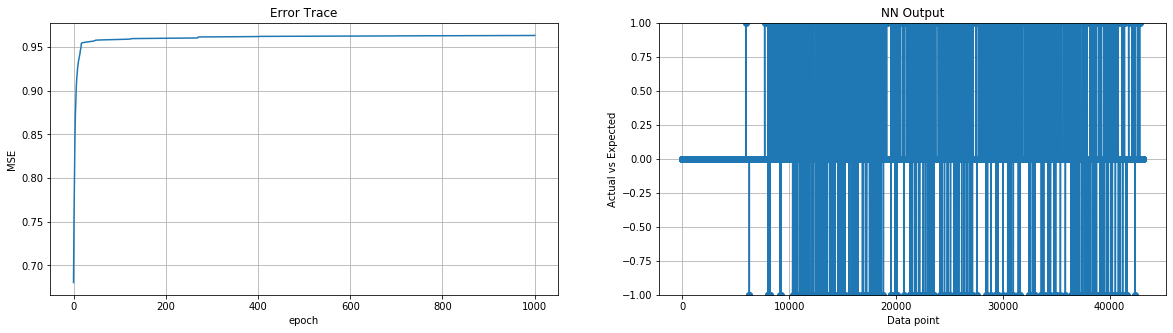

In [25]:
print_results(astr_pch_results_all)

In [26]:
%%capture
if os.path.isfile('astr_pch_results_split_file.data'):
    with open('astr_pch_results_split_file.data', 'rb') as filehandle:
        astr_pch_results_split = pickle.load(filehandle)
else: 
    astr_pch_results_split = run_test(num_inputs, class_list, Xtrain_pitch, Ttrain_pitch, Xtest_pitch, Ttest_pitch)
    with open('astr_pch_results_split_file.data', 'wb') as filehandle:
        pickle.dump(astr_pch_results_split, filehandle)


8377 out of 8632 samples or 97.05 percent.
Number of false positives(56)
Number of false negative (199)


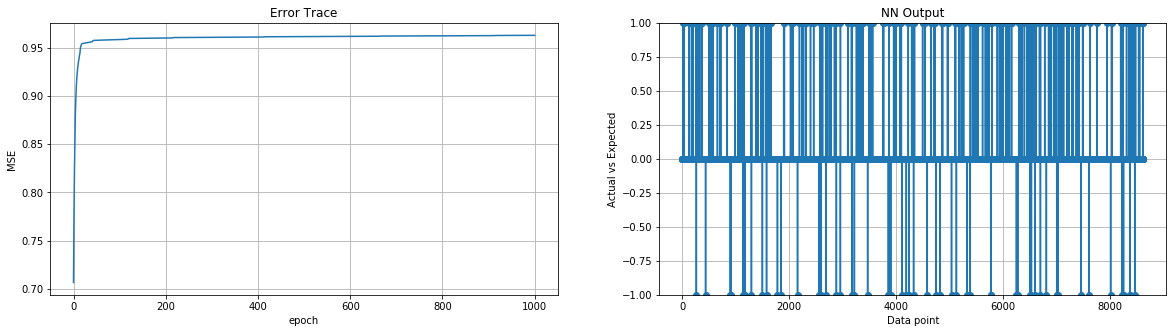

In [27]:
print_results(astr_pch_results_split)

In [28]:
# Get all data and partition into 80% training 20% test data
train_fld_data, test_fld_data = train_test_split(df_season_fielding, test_size=0.2)

# Get the input data and convert to numpy variables
Xdata_fld  = df_season_fielding.loc[:,'yearID':'ZR'].values
Xtrain_fld =     train_fld_data.loc[:,'yearID':'ZR'].values
Xtest_fld  =      test_fld_data.loc[:,'yearID':'ZR'].values

# Get the target values and convert to numpy variables
Tdata_fld  = df_season_fielding.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttrain_fld =     train_fld_data.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)
Ttest_fld  =      test_fld_data.loc[:,'all-star'].reset_index().values[:,1].reshape(-1, 1).astype(int)

# Extract info from the data sets
num_inputs = Xdata_fld.shape[1]
class_list = np.unique(Tdata_fld)

print(f'Xdata_fld.shape({Xdata_fld.shape}) Tdata_fld.shape({Tdata_fld.shape})')
print(f'num_inputs({num_inputs}) class_list({class_list})')

Xdata_fld.shape((49390, 27)) Tdata_fld.shape((49390, 1))
num_inputs(27) class_list([0 1])


In [29]:
%%capture
if os.path.isfile('astr_fld_results_all_file.data'):
    with open('astr_fld_results_all_file.data', 'rb') as filehandle:
        astr_fld_results_all = pickle.load(filehandle)
else: 
    astr_fld_results_all = run_test(num_inputs, class_list, Xdata_fld, Tdata_fld, Xdata_fld, Tdata_fld)
    with open('astr_fld_results_all_file.data', 'wb') as filehandle:
        pickle.dump(astr_fld_results_all, filehandle)


47243 out of 49390 samples or 95.65 percent.
Number of false positives(548)
Number of false negative (1599)


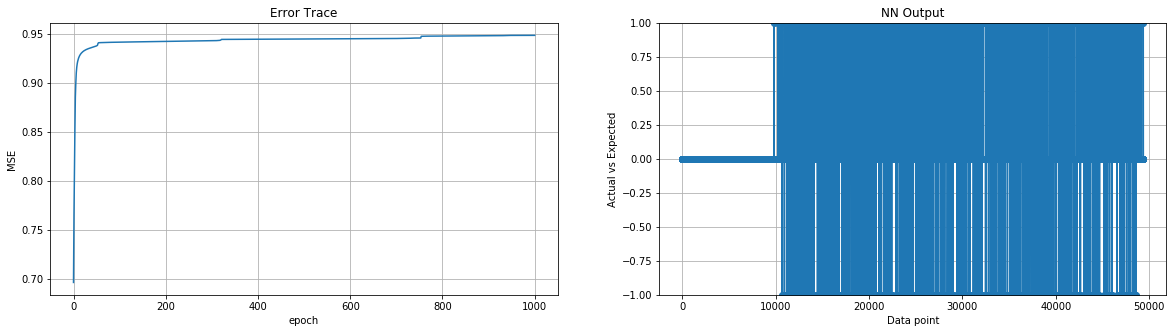

In [30]:
print_results(astr_fld_results_all)

In [31]:
%%capture
if os.path.isfile('astr_fld_results_split_file.data'):
    with open('astr_fld_results_split_file.data', 'rb') as filehandle:
        astr_fld_results_split = pickle.load(filehandle)
else: 
    astr_fld_results_split = run_test(num_inputs, class_list, Xtrain_fld, Ttrain_fld, Xtest_fld, Ttest_fld)
    with open('astr_fld_results_split_file.data', 'wb') as filehandle:
        pickle.dump(astr_fld_results_split, filehandle)

9399 out of 9878 samples or 95.15 percent.
Number of false positives(132)
Number of false negative (347)


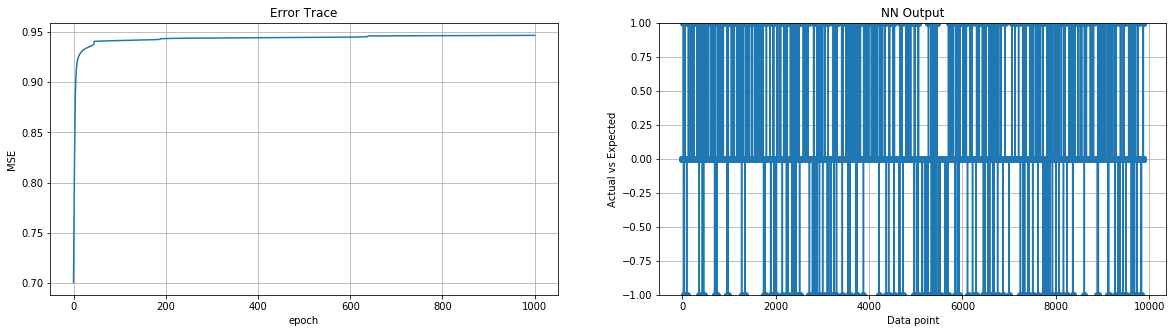

In [32]:
print_results(astr_fld_results_split)

## Analysis